# Setup

In [12]:
import json
import yaml
import matplotlib.pyplot as plt
import networkx as nx
import imageio
import torch

from dataset_road_network import build_road_network_data
from utils import image_graph_collate_road_network

from monai.data import DataLoader
from torchvision.transforms import Compose, Normalize
from matplotlib.pyplot import figure

In [13]:
class obj:
    def __init__(self, dict1):
        self.__dict__.update(dict1)

def dict2obj(dict1):
    return json.loads(json.dumps(dict1), object_hook=obj)

config_path = 'configs/road_rgb_2D.yaml'
# Load the config files
with open(config_path) as f:
    print('\n*** Config file')
    print(config_path)
    config = yaml.load(f, Loader=yaml.FullLoader)
    print(config['log']['message'])
config = dict2obj(config)

inv_norm = Compose([ 
    Normalize(
        mean = [ 0., 0., 0. ],
        std = [ 1/0.229, 1/0.224, 1/0.225 ]
    ),
    Normalize(
        mean = [ -0.485, -0.456, -0.406 ],
        std = [ 1., 1., 1. ]
    ),
])

def ensure_format(bboxes):
    boxes_new = []
    for bbox in bboxes:
        if bbox[0] > bbox[2]:
            bbox[0], bbox[2] = bbox[2], bbox[0]
        if bbox[1] > bbox[3]:
            bbox[1], bbox[3] = bbox[3], bbox[1]

        # to take care of horizontal and vertical edges
        if bbox[2]-bbox[0]<0.2:
            bbox[0] = bbox[0]-0.075
            bbox[2] = bbox[2]+0.075
        if bbox[3]-bbox[1]<0.2:
            bbox[1] = bbox[1]-0.075
            bbox[3] = bbox[3]+0.075

        boxes_new.append(bbox)
    return np.array(boxes_new)

def draw_graph(nodes, edges, row, column):
    # Create Graph for plotting graphs for actual data and prediction
    G = nx.Graph()

    # Add all nodes
    for ind, pos in enumerate(nodes):
        # The positions have to be altered so that the graph has the right orientation (all coordinates are normalized to [0,1])
        G.add_node(ind, pos=(pos[1].item(), 1 - pos[0].item()))

    # Add positions to nodes
    pos = nx.get_node_attributes(G,'pos')

    # Add all edges
    for edge in edges:
        G.add_edge(edge[0].item(), edge[1].item())

    # Draw Graphs with matplotlib
    nx.draw(G, pos, axs[row, column], node_size=20, with_labels=False)


*** Config file
configs/road_rgb_2D.yaml
Baseline 2D relationformer for 2D sat network


# Visualization of big picture of 20 US Cities Dataset

This is every 10th picture of the 20 US Cities Dataset

In [ ]:
set_name = "global_diverse_cities"
city_name_list = 'configs/cities.json'

step_size = 1
min_index = 0
max_index = 9

# Load city names from file
cities = []
dataset_cfg_ = json.load(open(city_name_list, "r"))
for item in dataset_cfg_:
    cities.append({"name": item["cityname"], "id": item["id"]})

root_dir = f"/media/data/alex_johannes/data/{set_name}"

rows = ((max_index - min_index) // step_size) // 3 + 1

fig, axs = plt.subplots(rows, 3)
fig.set_size_inches(20,rows * 6)
image_no = 0

for ind in range(min_index, max_index, step_size):
    try:
        sat_img = imageio.imread(root_dir + "/%s_region_%d_sat.png" % (city_names[ind], ind))
    except:
        sat_img = imageio.imread(root_dir + "/%s_region_%d_sat.jpg" % (city_names[ind], ind))

    # Add image to subplot
    axs[image_no // 3, image_no % 3].imshow(sat_img)

    # Turn off labels for axis for all graphs
    axs[image_no // 3, image_no % 3].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # Turn off labels for axis for all graphs
    axs[image_no // 3, image_no % 3].annotate(ind, (0,0))


    image_no += 1

# Visualization of actual training data
This is a visualization of the data that will be used for training (incl. Segmentation and Target graph) of 100 samples from the 20 US Cities dataset

/home/alex_johannes/relationformer/dataset_road_network.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_data = tvf.normalize(torch.tensor(


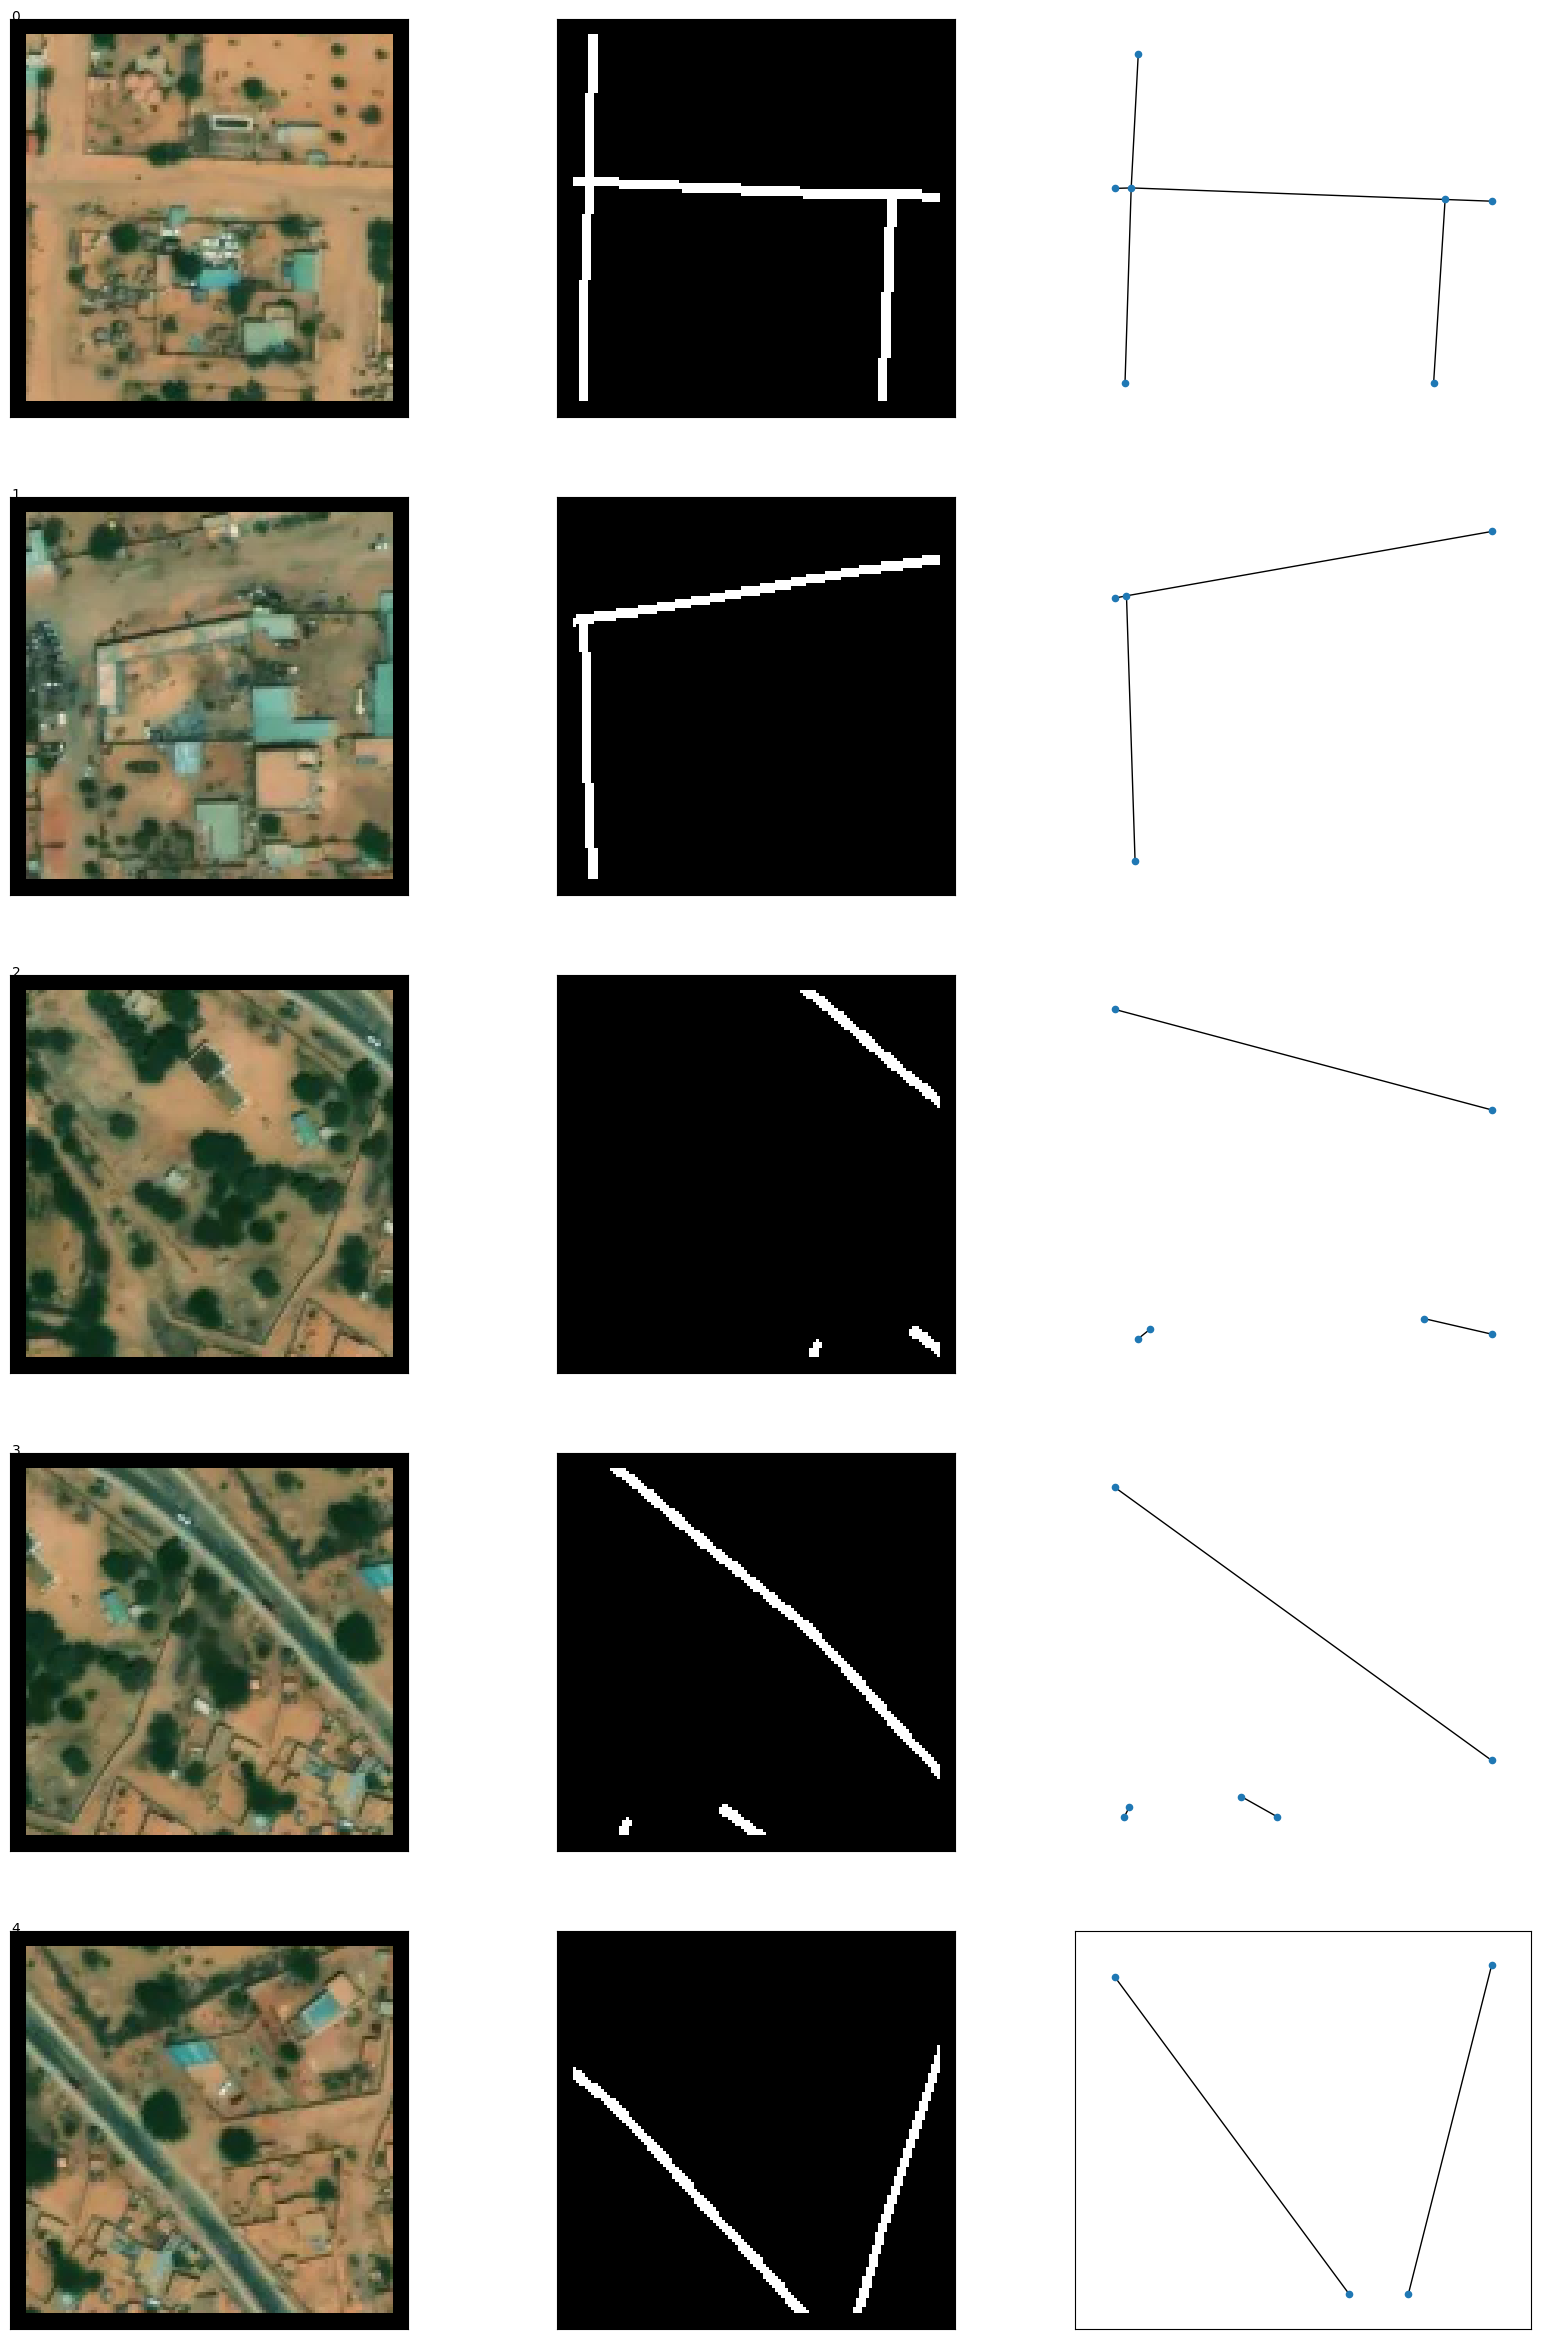

In [14]:
# Loading the data
ds = build_road_network_data(
    config, mode='test'
)

loader = DataLoader(
    ds,
    batch_size=config.DATA.BATCH_SIZE,
    shuffle=True,
    num_workers=config.DATA.NUM_WORKERS,
    collate_fn=image_graph_collate_road_network,
    pin_memory=True
)

num_samples = 5
start_index = 0

# Create figure with 3 plots
fig, axs = plt.subplots(num_samples, 3)
fig.set_size_inches(20,6 * num_samples)

for i in range(start_index, start_index + num_samples):

    # Selecting a sample
    sample = ds[i]

    # Preparing the sample (especially reversing the normalization)
    image, seg, nodes, edges = sample[0], sample[1], sample[2], sample[3]
    image = inv_norm(image)
    seg = torch.reshape(seg, (128,128))

    # Draw images
    axs[i, 0].imshow( image.permute(1,2,0) )
    axs[i, 1].imshow( seg, cmap='gray' )

    axs[i, 0].annotate(i, xy=(0,0))

    
    # Create Graph for plotting graph
    G = nx.Graph()

    # Add all nodes 
    for ind, pos in enumerate(nodes):
        # The positions have to be altered so that the graph has the right orientation (all cooridnates are normalized to [0,1])
        G.add_node(ind, pos=(pos[1].item(), 1 - pos[0].item()))

    # Add positions to nodes
    pos = nx.get_node_attributes(G,'pos')

    # Add all edges
    for edge in edges:
        G.add_edge(edge[0].item(), edge[1].item())

    # Draw Graph with matplotlib
    nx.draw(G, pos, axs[i, 2], node_size=20, with_labels=False)

    # Style the graph
    limits = plt.axis('on')
    



    # Turn off labels for axis for all graphs
    for x in axs[i]:
        x.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Show graph
plt.show()

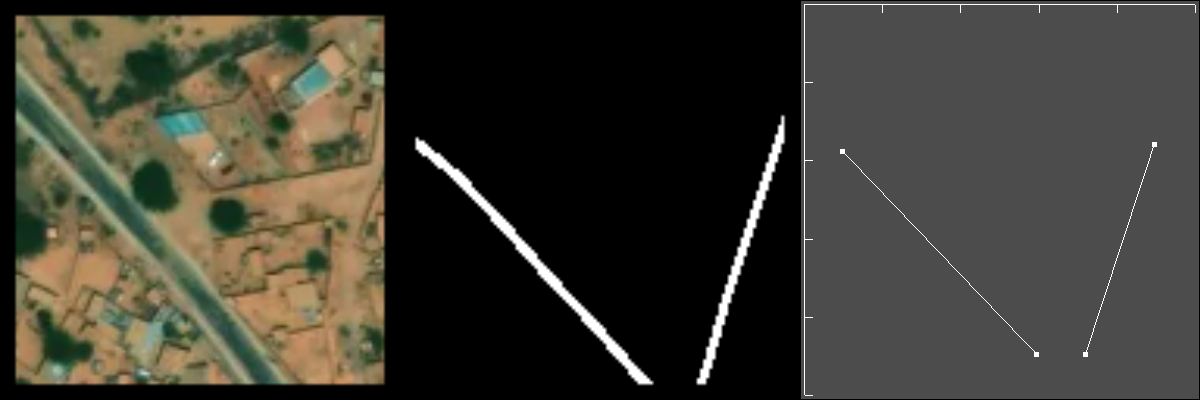

In [28]:
import os
import pyvista

image_id = '000003'

plotter = pyvista.Plotter(shape=(1,3))

vtk_folder = os.path.join('/media/data/alex_johannes/data/global_diverse_cities/agadez/test_data', 'vtp')
img_folder = os.path.join('/media/data/alex_johannes/data/global_diverse_cities/agadez/test_data', 'raw')
seg_folder = os.path.join('/media/data/alex_johannes/data/global_diverse_cities/agadez/test_data', 'seg')

# Showing sat image
plotter.subplot(0,0)
img_file = os.path.join(img_folder, f'sample_{image_id}_data.png')
plotter.add_background_image(img_file, as_global=False)

# Showing seg image
plotter.subplot(0,1)
seg_file = os.path.join(seg_folder, f'sample_{image_id}_seg.png')
plotter.add_background_image(seg_file, as_global=False)

# Plotting graph
plotter.subplot(0,2)
vtk_file = os.path.join(vtk_folder, f'sample_{image_id}_graph.vtp')
vtk_data = pyvista.read(vtk_file)
_ = plotter.add_mesh(vtk_data)
plotter.show_bounds(show_zaxis=False, bounds=[0,1,0,1,0,1])

# Fix orientation for graph
plotter.camera_position = 'xy'
plotter.camera.roll -= 90
plotter.camera.zoom(3.5)


# Show everything
plotter.window_size = [1200, 400]
plotter.show(jupyter_backend="static")


# Testing the model

## Importing things

In [3]:
import torch
from monai.data import DataLoader
from tqdm import tqdm
import numpy as np

from dataset_road_network import build_road_network_data
from models import build_model
from inference import relation_infer
from metric_smd import StreetMoverDistance
from metric_map import BBoxEvaluator
from box_ops_2D import box_cxcywh_to_xyxy_np
from utils import image_graph_collate_road_network
from metrics.topo import compute_topo

## Setting up Model & Dataloader

In [4]:
checkpoint = './trained_weights/supro/20_US_cities_checkpoint_epoch=80.pt'
max_rows = 21

# Loading the data
ds = build_road_network_data(
    config, mode='test'
)

loader = DataLoader(
    ds,
    batch_size=config.DATA.TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=config.DATA.NUM_WORKERS,
    collate_fn=image_graph_collate_road_network,
    pin_memory=True
)

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.multiprocessing.set_sharing_strategy('file_system')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

net = build_model(config).to(device)

# load checkpoint
checkpoint = torch.load(checkpoint, map_location='cpu')
net.load_state_dict(checkpoint['net'])
net.eval()

"""
Setting up metrics for quantitative evaluation
"""
# init metric
metric_smd = StreetMoverDistance(eps=1e-5, max_iter=10, reduction='none')
smd_results = []
topo_results = []

metric_node_map = BBoxEvaluator(['node'], max_detections=100)
metric_edge_map = BBoxEvaluator(['edge'], max_detections=100)

## Creating and plotting results

  0%|          | 0/241 [00:00<?, ?it/s]/home/bran/alex_johannes/relationformer/dataset_road_network.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_data, dtype=torch.float), mean=self.mean, std=self.std)
/home/bran/alex_johannes/relationformer/dataset_road_network.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_data, dtype=torch.float), mean=self.mean, std=self.std)
/home/bran/alex_johannes/relationformer/dataset_road_network.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_data, dtype=torch.float), mean=se

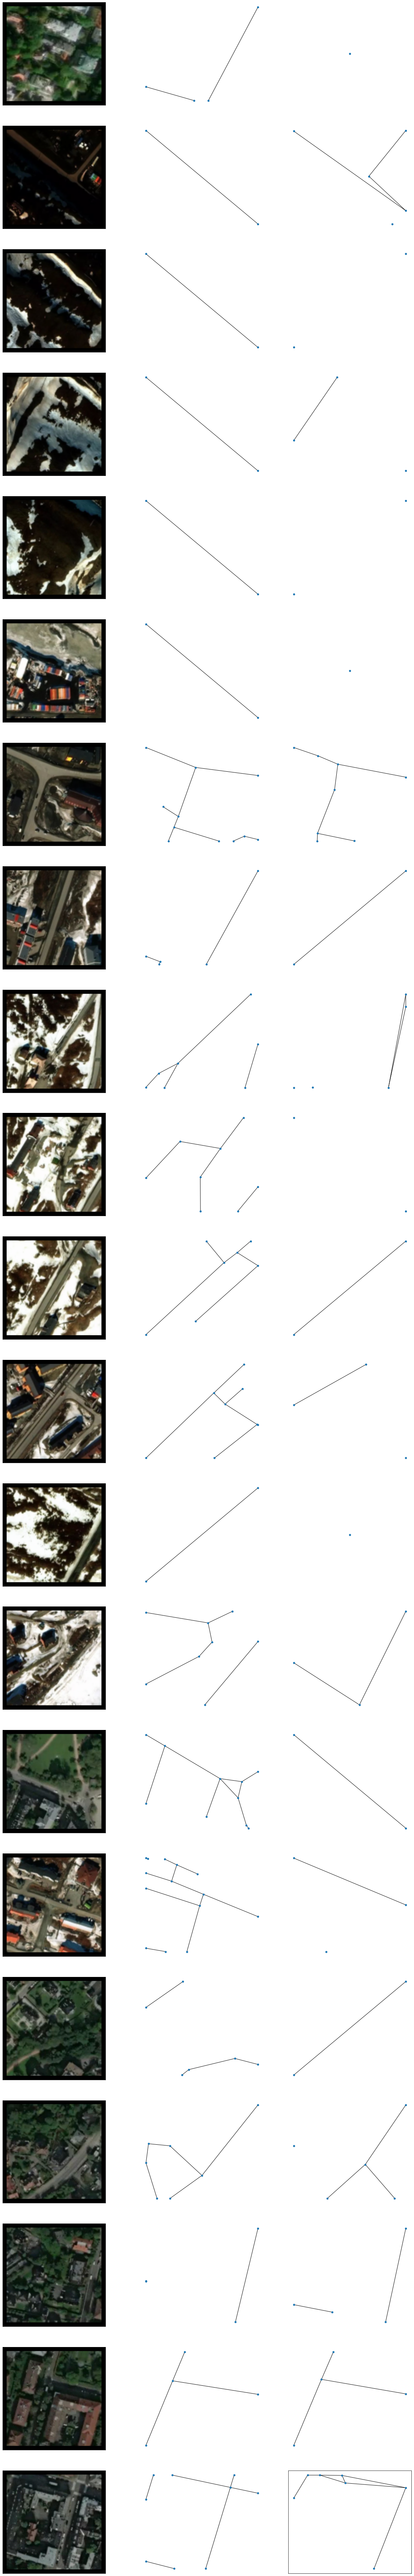

topo mean: [0.37857507 0.25843781]
smd value: mean 0.4795586168766022, std 0.46455997228622437

node mAP_IoU_0.50_0.95_0.05_MaxDet_100 0.039469780348757706
node mAR_IoU_0.50_0.95_0.05_MaxDet_100 0.07639546911514936
edge mAP_IoU_0.50_0.95_0.05_MaxDet_100 0.018220521810252476
edge mAR_IoU_0.50_0.95_0.05_MaxDet_100 0.039207005425123495


In [5]:
# Create figure with 3 plots per row
fig, axs = plt.subplots(max_rows, 3)
fig.set_size_inches(20,6 * max_rows)

row_counter = 0

with torch.no_grad():
    for batchdata in tqdm(loader):
        # extract data and put to device
        images, segs, nodes, edges = batchdata[0], batchdata[1], batchdata[2], batchdata[3]
        images = images.to(device,  non_blocking=False)
        segs = segs.to(device,  non_blocking=False)
        nodes = [node.to(device,  non_blocking=False) for node in nodes]
        edges = [edge.to(device,  non_blocking=False) for edge in edges]

        h, out, _ = net(images, seg=False)

        pred_nodes, pred_edges, pred_nodes_box, pred_nodes_box_score, pred_nodes_box_class, pred_edges_box_score, pred_edges_box_class = relation_infer(
            h.detach(), out, net, config.MODEL.DECODER.OBJ_TOKEN, config.MODEL.DECODER.RLN_TOKEN,
            nms=False, map_=True
        )

        if row_counter < max_rows:
            # Reverse normalization and draw satellite image
            image = inv_norm(images[0].cpu())
            axs[row_counter, 0].imshow( image.permute(1,2,0) )

            # Drawing the first sample (target and prediction) from the batch. Effectively a random sample if the dataloader is shuffling
            draw_graph(nodes[0], edges[0], row_counter, 1)
            draw_graph(pred_nodes[0], pred_edges[0], row_counter, 2)

            # Style the graph
            limits = plt.axis('on')
            #axs[counter, 2].set_box_aspect(1)

            # Turn off labels for axis for all graphs
            for x in axs[row_counter]:
                x.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

        row_counter += 1

        """
        Quantitative evaluation - copied from test.py
        """
        # Add smd of current batch elem
        ret = metric_smd(nodes, edges, pred_nodes, pred_edges)
        smd_results += ret.tolist()

        # Add elements of current batch elem to node map evaluator
        metric_node_map.add(
            pred_boxes=[box_cxcywh_to_xyxy_np(np.concatenate([nodes_.cpu().numpy(), np.ones_like(nodes_.cpu()) * 0.2], axis=1)) for nodes_ in pred_nodes],
            pred_classes=pred_nodes_box_class,
            pred_scores=pred_nodes_box_score,
            gt_boxes=[box_cxcywh_to_xyxy_np(np.concatenate([nodes_.cpu().numpy(), np.ones_like(nodes_.cpu()) * 0.2], axis=1)) for nodes_ in nodes],
            gt_classes=[np.ones((nodes_.shape[0],)) for nodes_ in nodes]
        )

        # Add elements of current batch elem to edge map evaluator
        pred_edges_box = []
        for edges_, nodes_ in zip(pred_edges, pred_nodes):
            nodes_ = nodes_.cpu().numpy()
            edges_box = ensure_format(np.hstack([nodes_[edges_[:, 0]], nodes_[edges_[:, 1]]]))
            pred_edges_box.append(edges_box)

        gt_edges_box = []
        for edges_, nodes_ in zip(edges, nodes):
            nodes_ , edges_ = nodes_.cpu().numpy(), edges_.cpu().numpy()
            edges_box = ensure_format(np.hstack([nodes_[edges_[:, 0]], nodes_[edges_[:, 1]]]))
            gt_edges_box.append(edges_box)

        metric_edge_map.add(
            pred_boxes=pred_edges_box,
            pred_classes=pred_edges_box_class,
            pred_scores=pred_edges_box_score,
            gt_boxes=gt_edges_box,
            gt_classes=[np.ones((edges_.shape[0],)) for edges_ in edges]
        )

        for node_, edge_, pred_node_, pred_edge_ in zip(nodes, edges, pred_nodes, pred_edges):
            topo_results.append(compute_topo(node_.cpu(), edge_.cpu(), pred_node_, pred_edge_))

# Show graph
plt.show()

# Summary of quantitative results
topo_array=np.array(topo_results)
print(f"topo mean: {topo_array.mean(0)}")
# Determine smd
smd_mean = torch.tensor(smd_results).mean().item()
smd_std = torch.tensor(smd_results).std().item()
print(f'smd value: mean {smd_mean}, std {smd_std}\n')

# Determine node box ap / ar
node_metric_scores = metric_node_map.eval()
print(f"node mAP_IoU_0.50_0.95_0.05_MaxDet_100 {node_metric_scores['mAP_IoU_0.50_0.95_0.05_MaxDet_100']}")
print(f"node mAR_IoU_0.50_0.95_0.05_MaxDet_100 {node_metric_scores['mAR_IoU_0.50_0.95_0.05_MaxDet_100']}")
# Determine edge box ap / ar
edge_metric_scores = metric_edge_map.eval()
print(f"edge mAP_IoU_0.50_0.95_0.05_MaxDet_100 {edge_metric_scores['mAP_IoU_0.50_0.95_0.05_MaxDet_100']}")
print(f"edge mAR_IoU_0.50_0.95_0.05_MaxDet_100 {edge_metric_scores['mAR_IoU_0.50_0.95_0.05_MaxDet_100']}")